# Theoretical distributions

This notebook provides an overview of how to use the `Distribution` classes from the `sim_tools.distributions` module.

The classes are a higher level abstract of sampling from the numpy library. They encapsulate the distribution parameters, a random number generator instance, and a random seed.  For example, the code for the Exponential class is:

```python
class Exponential:
    """
    Exponential distribution implementation.

    A probability distribution that models the time between events in a Poisson process,
    where events occur continuously and independently at a constant average rate.

    This class conforms to the Distribution protocol and provides methods to sample
    from an exponential distribution with a specified mean.
    """

    def __init__(
        self,
        mean: float,
        random_seed: Optional[Union[int, SeedSequence]] = None,
    ):
        """
        Initialize an exponential distribution.

        Parameters
        ----------
        mean : float
            The mean of the exponential distribution.
            Must be positive.

        random_seed : Optional[Union[int, SeedSequence]], default=None
            A random seed or SeedSequence to reproduce samples. If None, a unique
            sample sequence is generated.
        """
        self.rng = np.random.default_rng(random_seed)
        self.mean = mean

    def sample(
        self, size: Optional[Union[int, Tuple[int, ...]]] = None
    ) -> Union[float, NDArray[np.float64]]:
        """
        Generate random samples from the exponential distribution.

        Parameters
        ----------
        size : Optional[Union[int, Tuple[int, ...]]], default=None
            The number/shape of samples to generate:
            - If None: returns a single sample as a float
            - If int: returns a 1-D array with that many samples
            - If tuple of ints: returns an array with that shape

        Returns
        -------
        Union[float, NDArray[np.float64]]
            Random samples from the exponential distribution:
            - A single float when size is None
            - A numpy array of floats with shape determined by size parameter
        """
        return self.rng.exponential(self.mean, size=size)
    

```

Here we can see that the `__init__` method accepts the distribution mean plus a random seed to control sampling from a `np.random.Generator` object.  The creation of the generator is done by the super class `Distribution`

The `sample` method delegates work to the `np.random.Generator` object.

The abstraction into a class enables the distribution to be used as a simple parameter in a model.

For some classes there are no direct mappings to `numpy`.  Samples from these distributions are typically derived from other distributions. For example, `PearsonV` is an inverse gamma distribution.

```python
class PearsonV:
    """
    Pearson Type V distribution implementation (inverse Gamma distribution).

    Where alpha = shape, and beta = scale (both > 0).

    Law (2007, pg 293-294) defines the distribution as
    PearsonV(alpha, beta) = 1/Gamma(alpha, 1/beta) and notes that the
    PDF is similar to that of lognormal, but has a larger spike
    close to 0. It can be used to model the time to complete a task.

    For certain values of the shape parameter the mean and variance can be
    directly computed:

    mean = beta / (alpha - 1) for alpha > 1.0
    var = beta^2 / (alpha - 1)^2 × (alpha - 2) for alpha > 2.0

    This class conforms to the Distribution protocol.

    Alternative Sources:
    --------------------
    [1] https://riskwiki.vosesoftware.com/PearsonType5distribution.php
    [2] https://modelassist.epixanalytics.com/display/EA/Pearson+Type+5

    Notes:
    ------
    A good R package for Pearson distributions is PearsonDS
    https://www.rdocumentation.org/packages/PearsonDS/versions/1.3.0
    """

    def __init__(
        self,
        alpha: float,
        beta: float,
        random_seed: Optional[Union[int, SeedSequence]] = None,
    ):
        """
        Initialize a Pearson Type V distribution.

        Parameters
        ----------
        alpha : float
            Shape parameter. Must be > 0.

        beta : float
            Scale parameter. Must be > 0.

        random_seed : Optional[Union[int, SeedSequence]], default=None
            A random seed or SeedSequence to reproduce samples. If None, a unique
            sample sequence is generated.

        Raises
        ------
        ValueError
            If alpha or beta are not positive.
        """
        if alpha <= 0 or beta <= 0:
            raise ValueError("alpha and beta must be > 0")

        self.rng = np.random.default_rng(random_seed)
        self.alpha = alpha  # shape
        self.beta = beta  # scale

    def mean(self) -> float:
        """
        Calculate the mean of the Pearson Type V distribution.

        Returns
        -------
        float
            The theoretical mean of this distribution.

        Raises
        ------
        ValueError
            If alpha <= 1.0, as the mean is not defined in this case.
        """
        if self.alpha > 1.0:
            return self.beta / (self.alpha - 1)
        msg = "Cannot directly compute mean when alpha <= 1.0"
        raise ValueError(msg)

    def var(self) -> float:
        """
        Calculate the variance of the Pearson Type V distribution.

        Returns
        -------
        float
            The theoretical variance of this distribution.

        Raises
        ------
        ValueError
            If alpha <= 2.0, as the variance is not defined in this case.
        """
        if self.alpha > 2.0:
            return (self.beta**2) / (
                ((self.alpha - 1) ** 2) * (self.alpha - 2)
            )
        msg = "Cannot directly compute var when alpha <= 2.0"
        raise ValueError(msg)

    def sample(
        self, size: Optional[Union[int, Tuple[int, ...]]] = None
    ) -> Union[float, NDArray[np.float64]]:
        """
        Generate random samples from the Pearson Type V distribution.

        Parameters
        ----------
        size : Optional[Union[int, Tuple[int, ...]]], default=None
            The number/shape of samples to generate:
            - If None: returns a single sample as a float
            - If int: returns a 1-D array with that many samples
            - If tuple of ints: returns an array with that shape

        Returns
        -------
        Union[float, NDArray[np.float64]]
            Random samples from the Pearson Type V distribution:
            - A single float when size is None
            - A numpy array of floats with shape determined by size parameter
        """
        return 1 / self.rng.gamma(self.alpha, 1 / self.beta, size)
```

## Summary of implemented distributions

1. **Exponential**: This class is used for modeling the time between events in a Poisson process, where events occur continuously and independently at a constant average rate. It takes the mean of the distribution and an optional random seed as parameters.

2. **Bernoulli**: This class models a process where an event has only two possible outcomes (success or failure). It takes the probability of success and an optional random seed as parameters.

3. **Lognormal**: This class is used when the logarithm of a variable is normally distributed. It takes the mean and standard deviation of the lognormal distribution and an optional random seed as parameters.

4. **Normal**: This class models a process where a variable is normally distributed. It takes the mean and standard deviation of the normal distribution, a boolean to allow or disallow negative samples, and an optional random seed as parameters.

5. **Uniform**: This class models a process where all outcomes are equally likely. It takes the lower and upper range of the uniform distribution and an optional random seed as parameters.

6. **Triangular**: This class models a process where a variable is most likely to be at the mode (peak) and the probabilities decrease uniformly on either side. It takes the lower limit, mode, upper limit, and an optional random seed as parameters.

7. **FixedDistribution**: This class returns a fixed value, useful when a constant value is needed in a simulation. It takes a fixed value as a parameter.

8. **CombinationDistribution**: This class is used to model a process where the outcome is the sum of outcomes from multiple distributions. It takes multiple distribution instances as parameters.

9. **GroupedContinuousEmpirical**: This class is used to model a process based on observed data, where the probability of an outcome is proportional to its frequency in the data. To produce a continuous value, linear interpolation between bounds is used. It takes lower bounds (of a discrete empirical distribution), upper bounds, observed frequencies, and an optional random seed as parameters.

10. **Erlang**: This class is used for modeling the time between events in a Poisson process, where events occur continuously and independently at a constant average rate. The class is implemented to allow for users to input the mean, and stdev of the distribution as opposed to k and theta. This allows for compatibility of parameters with other commerical simulation packages. The mean and stdev are converted to k and theta internally. The Erlang is a special case of the gamma distribution where  is an integer.  Internally this is implemented using numpy Generator's gamma method. As k is calculated from the mean and stdev it is rounded to an integer value using python's built in 'round' function. Optionally a user can offet the original of the distribution using the location parameter.

11. **ErlangK**: The same as **Erlang**, but `k` and `theta` are specified directly by a user. 

12. The **Weibull** distribution class is characterized by a shape parameter (alpha) and a scale parameter (beta), both of which must be greater than zero. The scale parameter influences the variance of the samples. An optional location parameter can shift the distribution to set a lower bound. This distribution is useful for modeling the life duration of materials and systems, where the failure rate is not constant over time[1].

13. The **Gamma** distribution class is defined by an alpha (scale) and beta (shape) parameter. It includes methods to compute the mean and variance, as well as a static method to determine alpha and beta from a specified mean and variance. The Gamma distribution is often used to model waiting times for multiple events in a Poisson process.

14. The **Beta** distribution class accepts two shape parameters (alpha1 and alpha2) and can be rescaled to a specific range using lower and upper bounds. It is commonly used to model random variables that are constrained to an interval, such as proportions and percentages.

15. **DiscreteEmpirical** distribution class allows sampling from a set of values with given observed frequencies. It is particularly useful for modeling scenarios where outcomes have specific probabilities, such as routing percentages or entity classes.

16. **TruncatedDistribution** class can truncate any given distribution at a specified lower bound. It is useful when modeling variables that have a natural lower limit, ensuring that no sampled values fall below this threshold.

17. The **RawDiscreteEmpirical** distribution class enables sampling with replacement from a list of raw empirical values. This class is beneficial when no theoretical distribution fits the observed data well, and a non-parametric approach is preferred.

18. The **PearsonV** (Pearson type 5) distribution, also known as the inverse Gamma distribution, is characterized by two parameters: alpha (shape) and beta (scale), both of which must be greater than zero. It is particularly useful for modeling time delays where there is a minimum delay and the maximum delay is unbounded. The mean and variance of the Pearson Type V distribution can be directly computed for certain values of the shape parameter.

19. The **PearsonVI** (Pearson Type 6) distribution, an inverted beta distribution, is defined by three parameters: alpha1 (shape parameter 1), alpha2 (shape parameter 2), and beta (scale parameter), all of which must be greater than zero. The Pearson Type VI distribution can be used to model the time to complete tasks and is sampled using the transformation Pearson6(a1, a2, b) = b * X / (1 - X), where X is a Beta-distributed random variable with parameters alpha1 and alpha2. The mean and variance can be computed directly for certain values of the second shape parameter.

20. The **Hyperexoponential** distribution.  A continuous probability distribution that is a mixture (weighted sum) of exponential distributions. It has a higher coefficient of variation than a single exponential distribution, making it useful for modeling highly variable processes or heavy-tailed phenomena.

## Example output

The code below creates an instance of the distributions on offer. Here we used the `size` parameter in `sample()` to produce a large number of samples to allow for visualisation.

In [1]:
# pylint: disable=missing-module-docstring,invalid-name

# Import package to generate plots
import matplotlib.pyplot as plt

# Import a selection of distributions
from sim_tools.distributions import (
    Exponential,
    Poisson,
    Bernoulli,
    Lognormal,
    Normal,
    Uniform,
    Triangular,
    FixedDistribution,
    CombinationDistribution,
    GroupedContinuousEmpirical,
    Erlang,
    ErlangK,
    Weibull,
    Gamma,
    Beta,
    DiscreteEmpirical,
    PearsonV,
    PearsonVI,
    Hyperexponential
)

### Create plots

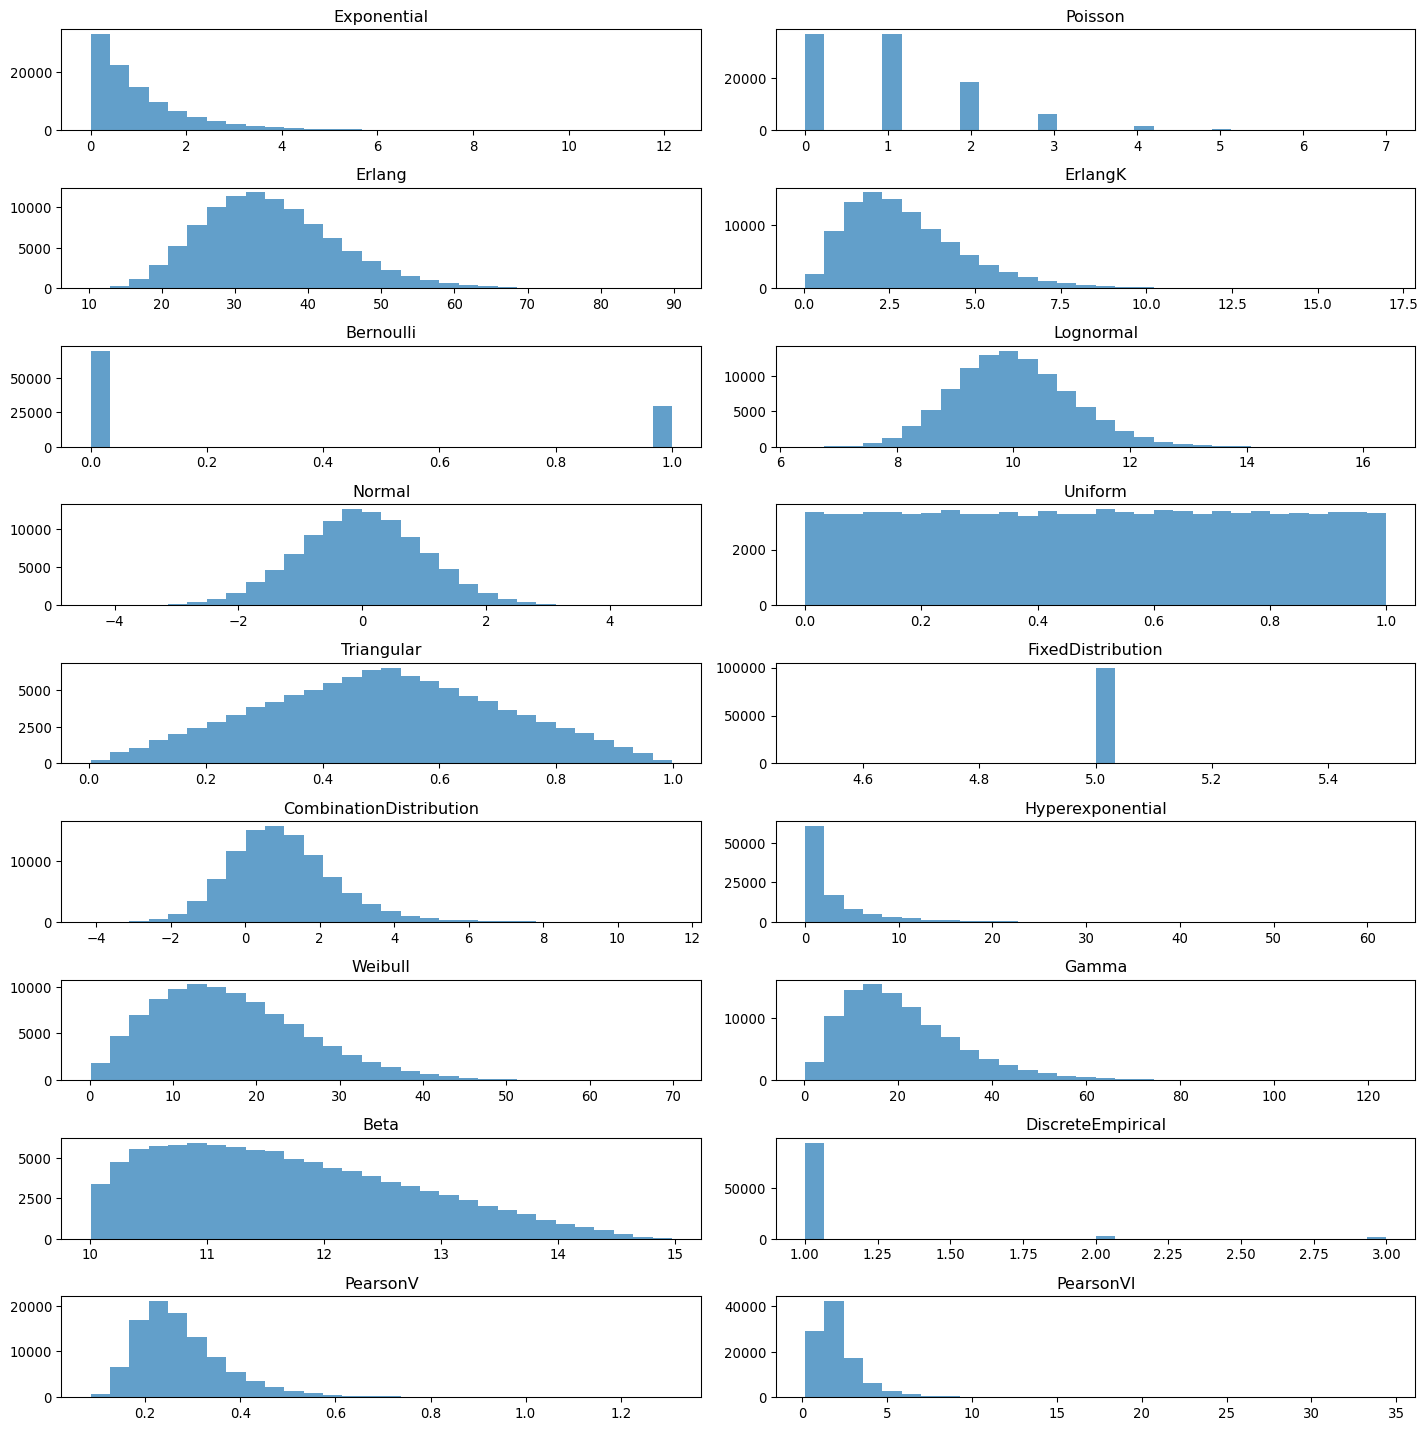

In [2]:
# Create an instance of each distribution and generate 10,000 samples
distributions = [
    Exponential(mean=1.0, random_seed=42),
    Poisson(rate=1.0, random_seed=42),
    Erlang(mean=32.0, stdev=9.26, location=2.83, random_seed=42),
    ErlangK(k=3, theta=1.0, location=0.0, random_seed=42),
    Bernoulli(p=0.3, random_seed=42),
    Lognormal(mean=10, stdev=1, random_seed=42),
    Normal(mean=0, sigma=1, minimum=None, random_seed=42),
    Uniform(low=0, high=1, random_seed=42),
    Triangular(low=0, mode=0.5, high=1, random_seed=42),
    FixedDistribution(value=5),
    CombinationDistribution(Exponential(mean=1.0), Normal(mean=0, sigma=1)),
    Hyperexponential([0.5, 0.5], [1.0, 0.2], random_seed=42),
    Weibull(alpha = 1.93, beta = 19.15, random_seed=42),
    Gamma(alpha = 2.84, beta = 7.42, location=0.0, random_seed=42),
    Beta(alpha1 = 1.32, alpha2 = 2.56, lower_bound=10.0, upper_bound=15.0,
         random_seed=42),
    DiscreteEmpirical(values=[1, 2, 3], freq=[95, 3, 2], random_seed=42),
    PearsonV(alpha=10.0, beta=2.5, random_seed=42),
    PearsonVI(alpha1=10.0, alpha2=5.0, beta=0.85, random_seed=42)

]

fig, axs = plt.subplots(len(distributions) // 2, 2, figsize=(15, 15))

for i, distribution in enumerate(distributions):
    row = i // 2
    col = i % 2
    samples = distribution.sample(size=100_000)
    axs[row, col].hist(samples, bins=30, alpha=0.7)
    axs[row, col].set_title(distribution.__class__.__name__)

fig.tight_layout()
plt.show()

## Single samples

In [3]:
arrival_dist = Exponential(mean=30, random_seed=42)
arrival_dist.sample()

72.12625811897983

In [4]:
activity_time = GroupedContinuousEmpirical(
    lower_bounds=[0, 5, 10, 15, 30, 45, 60, 120, 180, 240, 480],
    upper_bounds=[5, 10, 15, 30, 45, 60, 120, 180, 240, 480, 2880],
    freq=[34, 4, 8, 13, 15, 13, 19, 13, 9,  12, 73],
    random_seed=42,
)

activity_time.sample()

1297.0730413946362